In [35]:
import numpy as np
import pandas as pd
import warnings
import riskfolio as rp
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.display.float_format = '{:.2%}'.format

In [3]:
xl = pd.ExcelFile('wartosci_walorow_12_22.xlsx')
sheets = xl.sheet_names

merged = xl.parse(sheets.pop(0))
print(sheets)

for sheet in sheets:
    data = xl.parse(sheet)    
    merged = merged.merge(data, on='Date', how='left') 

xl.close()


['MSCI ACWI', 'MWITR', 'TBSP', 'EURPLN', 'Bloomberg Barclays Global Aggre', 'Gold spot price', 'Global aggregate euro hdg']


In [4]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 456 entries, 0 to 455
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Date             456 non-null    datetime64[ns]
 1   GovBondG7        456 non-null    float64       
 2   ACWI             421 non-null    float64       
 3   Mwig40tr         156 non-null    float64       
 4   TBSP             192 non-null    float64       
 5   EURPLN           255 non-null    float64       
 6   GlobalCorporate  124 non-null    float64       
 7   Gold             456 non-null    float64       
 8   GABHDG           62 non-null     float64       
dtypes: datetime64[ns](1), float64(8)
memory usage: 35.6 KB


In [5]:
assets = merged.columns[1:]
price_changes = merged[assets].pct_change()
price_changes.set_index(merged['Date'], inplace=True)

In [6]:
price_changes.to_excel('oryginal_price_changes.xlsx')

In [7]:
euro_assets = ['ACWI', 'GovBondG7', 'GlobalCorporate', 'Gold', 'GABHDG']
pln_assets = ['Mwig40tr', 'TBSP']

pln = merged[euro_assets].apply(lambda x: x * merged['EURPLN'])
pln_chng = pln.pct_change()
pln_chng.set_index(merged['Date'], inplace=True)
pln_chng = pd.merge(price_changes[pln_assets], pln_chng, left_index=True, right_index=True)

In [8]:
#pln_chng.to_excel('pln_price_changes2.xlsx')
pln_chng.to_csv('pln_price_changes2.csv', float_format='%.3f')

In [9]:
assets = pln_chng
assets.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 456 entries, 1985-01-01 to 2022-12-01
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Mwig40tr         155 non-null    float64
 1   TBSP             191 non-null    float64
 2   ACWI             254 non-null    float64
 3   GovBondG7        254 non-null    float64
 4   GlobalCorporate  123 non-null    float64
 5   Gold             254 non-null    float64
 6   GABHDG           61 non-null     float64
dtypes: float64(7)
memory usage: 44.7 KB


In [92]:
def annullised_mean(series):
    return np.mean(series)*12

def annullised_std(series):
    return np.std(series) * np.sqrt(12)

def pstd(weights, cov_matrix):
    #variance = np.transpose(weights)@cov_matrix@weights
    variance = np.dot(weights.T, np.dot(cov_matrix, weights))
    return np.sqrt(variance)

def pmean(weightsDf, means):  
    weights = weightsDf
    return np.sum(weights * means)

def portfolioMeasures(weights,means,cov_table):
    mu = np.apply_along_axis(pmean,1,weights, means=means)
    std = np.apply_along_axis(pstd,1,weights, cov_matrix=cov_table) 
    return np.array([mu,std]).T

In [17]:
perf60 = assets.iloc[-60:].agg(['mean', np.std])
perf60.iloc[0,:] = perf60.iloc[0,:]*12
perf60.iloc[1,:] = perf60.iloc[1,:] * np.sqrt(12)
perf60

,Mwig40tr,TBSP,ACWI,GovBondG7,GlobalCorporate,Gold,GABHDG
mean,2.32%,0.00%,11.67%,2.38%,4.06%,11.94%,0.80%
std,21.69%,5.83%,18.02%,8.12%,9.34%,12.30%,8.55%


In [29]:
corr60 = assets.iloc[-60:].corr(method='pearson')
#corr60 = assets.iloc[-60:].cov()
corr60.style.format("{:.2%}").background_gradient(cmap='YlGn')

,Mwig40tr,TBSP,ACWI,GovBondG7,GlobalCorporate,Gold,GABHDG
Mwig40tr,100.00%,4.29%,-30.80%,-41.21%,-38.10%,-22.17%,-37.96%
TBSP,4.29%,100.00%,-5.04%,-4.58%,-2.29%,6.80%,8.64%
ACWI,-30.80%,-5.04%,100.00%,37.32%,70.60%,9.68%,57.11%
GovBondG7,-41.21%,-4.58%,37.32%,100.00%,85.02%,47.04%,59.25%
GlobalCorporate,-38.10%,-2.29%,70.60%,85.02%,100.00%,38.44%,66.15%
Gold,-22.17%,6.80%,9.68%,47.04%,38.44%,100.00%,39.38%
GABHDG,-37.96%,8.64%,57.11%,59.25%,66.15%,39.38%,100.00%


In [66]:
perf120 = assets.iloc[-120:].agg(['mean', np.std])
perf120.iloc[0,:] = perf120.iloc[0,:]*12
perf120.iloc[1,:] = perf120.iloc[1,:] * np.sqrt(12)
perf120

,Mwig40tr,TBSP,ACWI,GovBondG7,GlobalCorporate,Gold,GABHDG
mean,9.26%,1.90%,12.81%,2.56%,4.72%,5.43%,0.69%
std,17.89%,4.73%,15.21%,8.94%,9.33%,15.28%,8.48%


In [65]:
corr120 = assets.iloc[-120:].corr(method='pearson')
#corr120 = assets.iloc[-120:].cov()
corr120.style.format("{:.2%}").background_gradient(cmap='YlGn')

,Mwig40tr,TBSP,ACWI,GovBondG7,GlobalCorporate,Gold,GABHDG
Mwig40tr,100.00%,4.09%,-26.05%,-35.52%,-34.43%,-29.45%,-37.71%
TBSP,4.09%,100.00%,-9.22%,-15.34%,-12.34%,-7.32%,8.52%
ACWI,-26.05%,-9.22%,100.00%,40.48%,69.42%,16.35%,57.15%
GovBondG7,-35.52%,-15.34%,40.48%,100.00%,89.02%,55.72%,59.24%
GlobalCorporate,-34.43%,-12.34%,69.42%,89.02%,100.00%,47.14%,66.16%
Gold,-29.45%,-7.32%,16.35%,55.72%,47.14%,100.00%,39.48%
GABHDG,-37.71%,8.52%,57.15%,59.24%,66.16%,39.48%,100.00%


In [87]:
perf180 = assets.iloc[-150:].agg(['mean', np.std])
perf180.iloc[0,:] = perf180.iloc[0,:]*12
perf180.iloc[1,:] = perf180.iloc[1,:] * np.sqrt(12)
perf180

,Mwig40tr,TBSP,ACWI,GovBondG7,GlobalCorporate,Gold,GABHDG
mean,8.38%,3.07%,12.37%,2.72%,4.44%,6.56%,0.69%
std,17.63%,4.40%,15.03%,9.98%,9.25%,16.38%,8.48%


In [88]:
corr180 = assets.iloc[-150:].corr(method='pearson')
#corr120 = assets.iloc[-120:].cov()
corr180.style.format("{:.2%}").background_gradient(cmap='YlGn')

,Mwig40tr,TBSP,ACWI,GovBondG7,GlobalCorporate,Gold,GABHDG
Mwig40tr,100.00%,6.49%,-29.47%,-41.78%,-34.82%,-27.75%,-37.71%
TBSP,6.49%,100.00%,-13.44%,-16.44%,-13.38%,-8.90%,8.52%
ACWI,-29.47%,-13.44%,100.00%,35.53%,69.42%,17.75%,57.15%
GovBondG7,-41.78%,-16.44%,35.53%,100.00%,88.76%,52.15%,59.24%
GlobalCorporate,-34.82%,-13.38%,69.42%,88.76%,100.00%,47.66%,66.16%
Gold,-27.75%,-8.90%,17.75%,52.15%,47.66%,100.00%,39.48%
GABHDG,-37.71%,8.52%,57.15%,59.24%,66.16%,39.48%,100.00%


<AxesSubplot:xlabel='Date'>

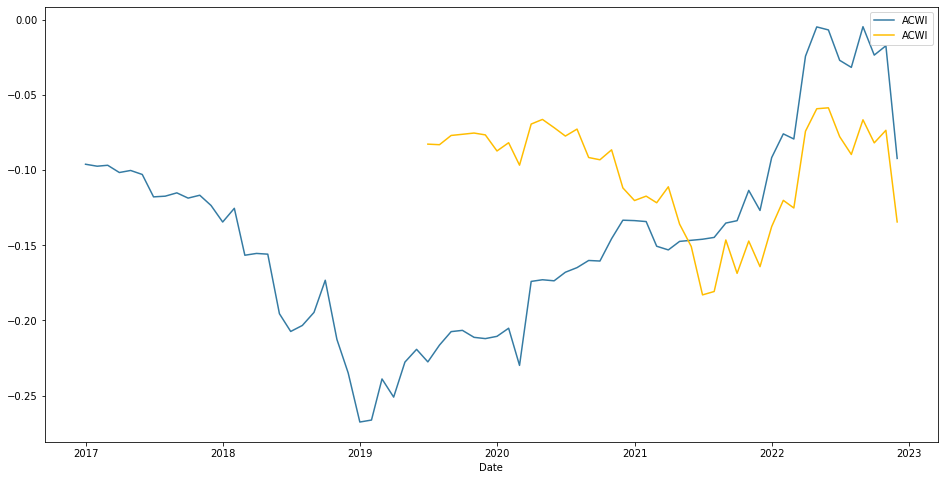

In [90]:
moving_corr = assets[['ACWI']].rolling(120).corr(assets['TBSP'])
moving_corr60 = assets[['ACWI']].rolling(150).corr(assets['TBSP'])
fig, ax = plt.subplots(figsize=(16,8))
sns.lineplot(data=moving_corr, ax=ax, palette='mako')
sns.lineplot(data=moving_corr60, ax=ax, palette='Wistia_r')

Index(['Mwig40tr', 'TBSP', 'ACWI', 'GovBondG7', 'GlobalCorporate', 'Gold',
       'GABHDG'],
      dtype='object')

In [129]:
#assets ['Mwig40tr', 'TBSP', 'ACWI', 'GovBondG7', 'GlobalCorporate', 'Gold', 'GABHDG']

porfolio_assets = assets[['Mwig40tr', 'TBSP', 'ACWI', 'Gold']]
port = rp.Portfolio(porfolio_assets[-150:])

method_mu='hist' # Method to estimate expected returns based on historical data.
method_cov='hist' # Method to estimate covariance matrix based on historical data.

port.assets_stats(method_mu=method_mu, method_cov=method_cov, d=0.94)

points = 10 # Number of points of the frontier
model='Classic' # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)
rm =  'MV' #'MV' vs 'MDD' # Risk measure used, this time will be variance
hist = True # Use historical scenarios for risk measures that depend on scenarios
rf = 0.00 # Risk free rate

frontier = port.efficient_frontier(model=model, rm=rm, points=points, rf=rf, hist=hist)

display(frontier.T.head(20))




,Mwig40tr,TBSP,ACWI,Gold
0,7.60%,74.83%,10.12%,7.45%
1,18.85%,42.84%,27.90%,10.40%
2,24.65%,26.40%,37.04%,11.91%
3,29.76%,11.84%,45.14%,13.26%
4,33.58%,0.00%,54.12%,12.30%
5,31.67%,0.00%,67.04%,1.29%
6,21.74%,0.00%,78.26%,0.00%
7,13.50%,0.00%,86.50%,0.00%
8,6.45%,0.00%,93.55%,0.00%
9,0.00%,0.00%,100.00%,0.00%


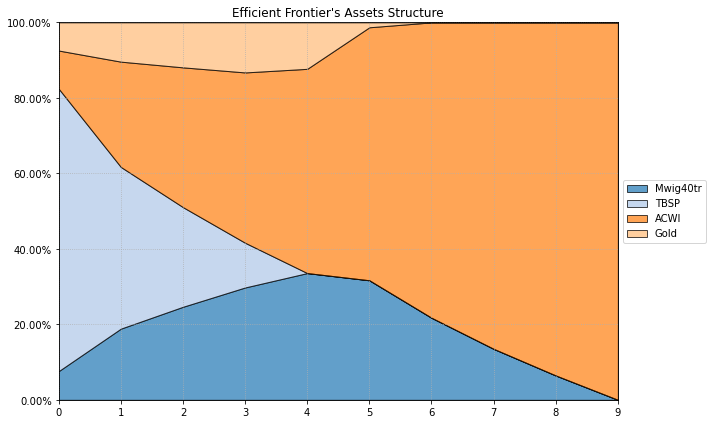

In [130]:
ax = rp.plot_frontier_area(w_frontier=frontier, cmap="tab20", height=6, width=10, ax=None)

In [131]:
porfolio_assets[-150:].cov().to_numpy()
frontier.values.T
porfolio_assets[-150:].mean().values.T*12

array([0.0838378 , 0.03067022, 0.12365509, 0.06559336])

In [132]:
measures = portfolioMeasures(frontier.values.T,porfolio_assets[-150:].mean().values.T, porfolio_assets[-150:].cov().to_numpy())
measures[:,0] = measures[:,0]*12
measures[:,1] = measures[:,1]*np.sqrt(12)
measures

array([[0.04672458, 0.03677211],
       [0.07027064, 0.04938515],
       [0.08237778, 0.06199814],
       [0.09309492, 0.07461115],
       [0.10314184, 0.08722414],
       [0.11029498, 0.09983715],
       [0.11499831, 0.11245016],
       [0.11827806, 0.12506317],
       [0.1210875 , 0.13767618],
       [0.12365509, 0.15028918]])

In [81]:
#params estimation
#assets ['Mwig40tr', 'TBSP', 'ACWI', 'GovBondG7', 'GlobalCorporate', 'Gold', 'GABHDG']

porfolio_assets = assets[['Mwig40tr', 'TBSP', 'ACWI', 'Gold']]
port = rp.Portfolio(porfolio_assets[-150:])

method_mu='hist' # Method to estimate expected returns based on historical data.
method_cov='ledoit' # Method to estimate covariance matrix based on historical data.

port.assets_stats(method_mu=method_mu, method_cov=method_cov, d=0.94)

points = 15 # Number of points of the frontier
model='Classic' # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)
rm =  'MV' #'MV' vs 'MDD' # Risk measure used, this time will be variance
hist = True # Use historical scenarios for risk measures that depend on scenarios
rf = 0.00 # Risk free rate

frontier = port.efficient_frontier(model=model, rm=rm, points=points, rf=rf, hist=hist)

display(frontier.T.head(20))


,Mwig40tr,TBSP,ACWI,Gold
0,14.15%,57.81%,15.51%,12.53%
1,21.84%,34.94%,29.77%,13.45%
2,25.38%,24.42%,36.33%,13.88%
3,28.31%,15.68%,41.78%,14.23%
4,30.97%,7.77%,46.71%,14.54%
5,33.46%,0.35%,51.34%,14.84%
6,32.35%,0.00%,59.62%,8.03%
7,31.32%,0.00%,66.37%,2.31%
8,26.86%,0.00%,73.14%,0.00%
9,21.02%,0.00%,78.98%,0.00%


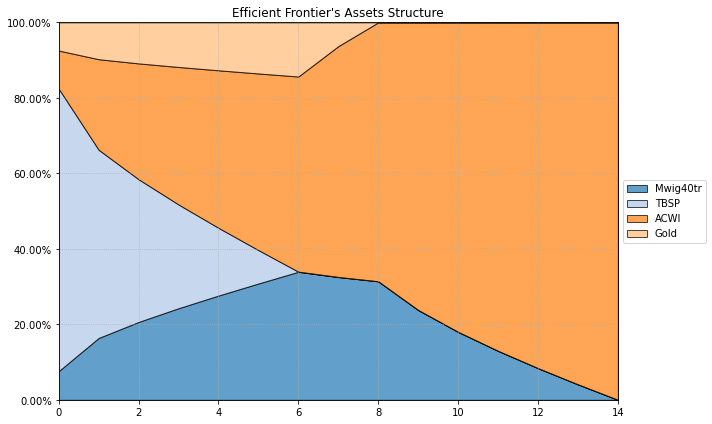

In [86]:
ax = rp.plot_frontier_area(w_frontier=frontier, cmap="tab20", height=6, width=10, ax=None)

In [ ]:
portfolioMeasures()